In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r"./Twitter_df.csv", header=0, low_memory=False)
df.tail()

,TweetID,Day,Hour,Lang,IsReshare,Reach,RetweetCount,Likes,Sentiment,text,LocationID,UserID
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail(3)

,TweetID,Day,Hour,Lang,IsReshare,Reach,RetweetCount,Likes,Sentiment,text,LocationID,UserID
994,tw-683739842673520640,Sunday,13.0,en,False,17422.0,0.0,0.0,0.0,Ace the Amazon Web Services Certification Exam...,82.0,tw-22445925
995,tw-683740297575051265,Sunday,13.0,en,False,710.0,0.0,0.0,0.0,@shfitriah aws .. English stfu,1885.0,tw-552022479
996,tw-683741220896641025,Sunday,13.0,en,True,1691.0,103.0,0.0,0.0,RT @docker: Deploy Docker on AWS easily with t...,5394.0,tw-17711081


In [4]:
df.drop(labels=[' Lang', ' IsReshare', ' Likes', ' text', ' UserID'], axis=1, inplace=True)
df.tail(3)

,TweetID,Day,Hour,Reach,RetweetCount,Sentiment,LocationID
994,tw-683739842673520640,Sunday,13.0,17422.0,0.0,0.0,82.0
995,tw-683740297575051265,Sunday,13.0,710.0,0.0,0.0,1885.0
996,tw-683741220896641025,Sunday,13.0,1691.0,103.0,0.0,5394.0


In [5]:
df['TweetID'] = pd.Series([int(each[3:]) for each in df['TweetID'].tolist()], name='TweetID')
df.tail(3)

,TweetID,Day,Hour,Reach,RetweetCount,Sentiment,LocationID
994,683739842673520640,Sunday,13.0,17422.0,0.0,0.0,82.0
995,683740297575051265,Sunday,13.0,710.0,0.0,0.0,1885.0
996,683741220896641025,Sunday,13.0,1691.0,103.0,0.0,5394.0


In [6]:
df.groupby('Day').count()

,TweetID,Hour,Reach,RetweetCount,Sentiment,LocationID
Day,,,,,,
Friday,383,383,383,383,383,383
Saturday,322,322,322,322,322,322
Sunday,201,201,201,201,201,201
Thursday,91,91,91,91,91,91


In [7]:
df_X, df_Y = df.loc[:, ~df.columns.isin(['Day'])], df.loc[:, ['Day']]
X, Y = df_X.to_numpy(), df_Y.to_numpy().reshape(-1)

In [8]:
from sklearn.preprocessing import MinMaxScaler as scale
X[:,:] = scale().fit_transform(X[:,:])

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(Type, threshold):
    plt.figure(figsize=(15,8))
    dn = dendrogram(linkage(X, Type), leaf_rotation=45, leaf_font_size=2,
                    above_threshold_color="#eeeeee", color_threshold=threshold, orientation='right')
    plt.axvline(x=threshold, c='grey', linestyle='dashed')
    plt.show()


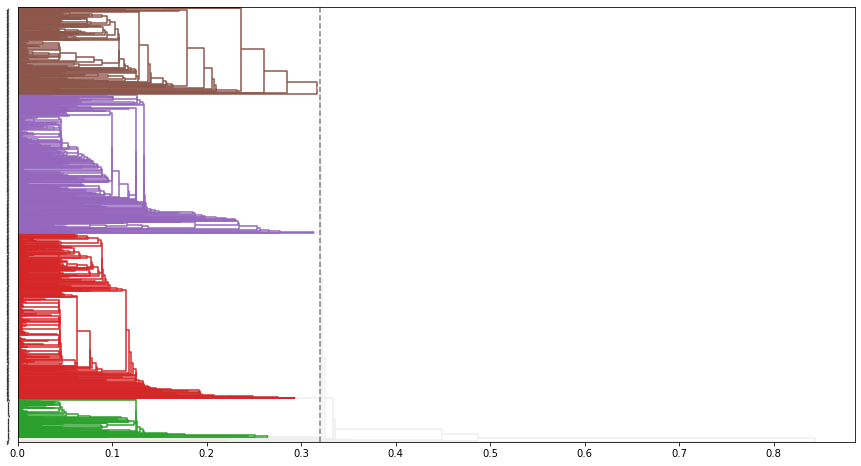

In [10]:
plot_dendrogram(Type='single', threshold=0.32)

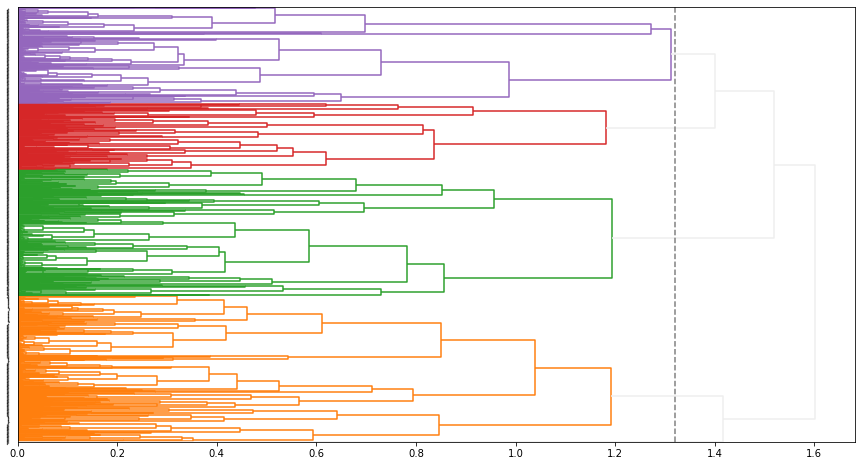

In [11]:
plot_dendrogram(Type='complete', threshold=1.32)

In [12]:
from tqdm.notebook import tqdm
from collections import Counter

In [13]:
def euclidean_distance(i, j):
    if i > j:
        # lower triangle
        x1, x2 = X[i], X[j]
        res = 0.0
        for k in range(len(x1)):
            res += np.power(x1[k] - x2[k], 2)
        return np.sqrt(res)
    else:
        # upper triangle and diagonal
        return 0.0

def most_similar(df):
    dic = {'val': 1e9, 'i': -1, 'j': -1}
    for i in range(len(df)):
        for j in range(i):
            if dic['val'] > df.iloc[i,j]:
                dic['val'] = df.iloc[i,j]
                dic['i'], dic['j'] = i, j
    return dic['val'], dic['i'], dic['j']


In [14]:
def clusters_by_threshold(X, Type):
    if Type == 'single': threshold=0.32
    elif Type == 'complete': threshold=1.32
    else: raise Exception('use proper type')
    
    len_X = len(X)
    dist = pd.DataFrame([[euclidean_distance(i, j) for j in range(len_X)] for i in range(len_X)],
                        columns=[str(i+1) for i in range(len_X)], index=[str(i+1) for i in range(len_X)])
    
    for i in tqdm(range(len(dist)-1)):
        d, i, j = most_similar(dist)
        if d > threshold: break
        
        label = dist.columns[j]+','+dist.columns[i]
        if Type == 'single':
            clus_ij = pd.DataFrame([[min(dist.iloc[max(i,k),min(i,k)], dist.iloc[max(j,k),min(j,k)]) for k in range(len(dist)) if k not in [i, j]]])
        else:
            clus_ij = pd.DataFrame([[max(dist.iloc[max(i,k),min(i,k)], dist.iloc[max(j,k),min(j,k)]) for k in range(len(dist)) if k not in [i, j]]])

        dist.drop(dist.index[[i,j]], axis=0, inplace=True)
        dist.drop(dist.columns[[i,j]], axis=1, inplace=True)

        clus_ij.index, clus_ij.columns = [label], dist.columns
        dist = pd.concat([dist, clus_ij], axis=0)
        dist[label]=0.0
    
    return [[int(idx)-1 for idx in each.split(',')] for each in dist.index.tolist()]


In [15]:
clusters = clusters_by_threshold(X, 'single')
clusters_type = [Counter([Y[each] for each in clusters[i]]) for i in range(len(clusters))]

  0%|          | 0/996 [00:00<?, ?it/s]

In [16]:
dic = {'None': 0, 'Friday': 0, 'Sunday': 0, 'Saturday': 0, 'Thursday': 0}
clus_day = {}
clus_no = ['None'] * len(X)
for i, each_clus in enumerate(cluss):
    clus_name = 'clus_'+str(i+1)
    for each in each_clus:
        clus_no[each] = clus_name
    most_occured, most_value = cluss_type[i].most_common(1)[0]
    if dic[most_occured] < most_value:
        dic['None'] += dic[most_occured]
        dic[most_occured] = most_value
        clus_day[most_occured] = clus_name
    else:
        dic['None'] += most_value
clus_day = dic(zip(clus_day.values(),clus_day.keys()))
print(dic)
print('Accuracy =', np.round(100 - 100*dic['None']/sum(dic.values()), 3), '%')

{'None': 8, 'Friday': 379, 'Sunday': 199, 'Saturday': 320, 'Thursday': 91}
Accuracy = 99.198 %


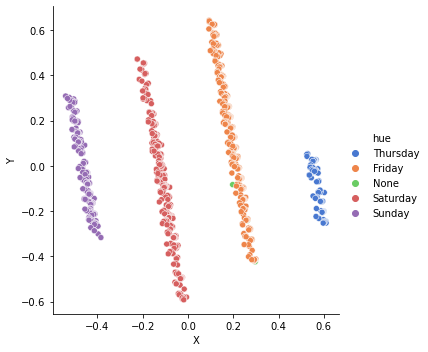

In [20]:
data_visualize = pd.DataFrame(PCA(2).fit_transform(X), columns=['X','Y'])
data_visualize['hue'] = [cluster_day[each] if each in cluster_day.keys() else 'None' for each in cluster_no]
sns.relplot(data=data_visualize, x='X', y='Y', hue='hue', palette="muted")
plt.show()

In [21]:
clusters = get_the_clusters_by_threshold(X, 'complete')
clusters_type = [Counter([Y[each] for each in clusters[i]]) for i in range(len(clusters))]

  0%|          | 0/996 [00:00<?, ?it/s]

In [25]:
dic = {'None': 0, 'Friday': 0, 'Sunday': 0, 'Saturday': 0, 'Thursday': 0}
clus_day = {}
clus_no = ['None'] * len(X)
for i, each_clus in enumerate(cluss):
    clus_name = 'clus_'+str(i+1)
    for each in each_clus:
        clus_no[each] = clus_name
    most_occured, most_value = cluss_type[i].most_common(1)[0]
    if dic[most_occured] < most_value:
        dic['None'] += dic[most_occured]
        dic[most_occured] = most_value
        clus_day[most_occured] = clus_name
    else:
        dic['None'] += most_value
clus_day = dic(zip(clus_day.values(),clus_day.keys()))
print(dic)
print('Accuracy =', np.round(100 - 100*dic['None']/sum(dic.values()), 3), '%')

{'Friday': 1}
{'Sunday': 48, 'Saturday': 100, 'Friday': 3}
{'Friday': 155, 'Thursday': 91, 'Saturday': 88}
{'Friday': 176, 'Saturday': 45, 'Sunday': 70}
{'Saturday': 89, 'Sunday': 83, 'Friday': 48}
{'None': 245, 'Friday': 176, 'Sunday': 0, 'Saturday': 100, 'Thursday': 0}
Accuracy = 52.975 %


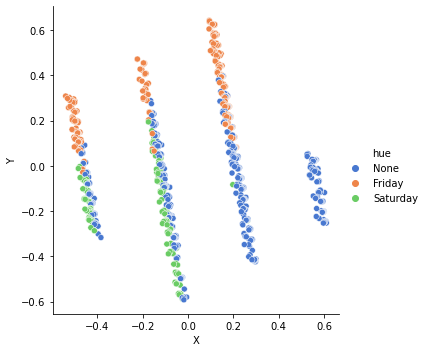

In [23]:
data_visualize = pd.DataFrame(PCA(2).fit_transform(X), columns=['X','Y'])
data_visualize['hue'] = [cluster_day[each] if each in cluster_day.keys() else 'None' for each in cluster_no]
sns.relplot(data=data_visualize, x='X', y='Y', hue='hue', palette="muted")
plt.show()